# `hw3`: Bayesian inference of Oxygen Saturation from Photoplethysmography


Deadline: **Friday, December 13, 11:59 PM**. 
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- Homeworks are carried out *individually*.

In [6]:
# Fill in this cell with your personal details:
# - Name: GUENFOUDI Ihabe
# - Student ID: s194071
# - Email: ihabe.guenfoudi@student.uliege.be

In this homework, you will have to infer oxygen saturation (SPO2 / SO2) measures from unprocessed photoplethysmography (PPG) using data from the [OpenOximetry Repository](https://physionet.org/content/openox-repo/1.0.1). More precisely, you will build a small probabilistic model of PPG from SpO2, and infer some physical parameters along with the unknown SpO2 from the observed PPG data. See homework 1 for instructions on how to handle the dataset, and homework 2 for instruction on how to prepare the data for inference.

## Oximeter

An [oximeter](https://en.wikipedia.org/wiki/Pulse_oximetry) is a medical device that estimates the **blood oximetry**, or **oxygen saturation** ($\text{SpO2}$), using the two [photoplethysmographs](https://en.wikipedia.org/wiki/Photoplethysmogram) obtained by illuminating the skin at two different wavelengths (red at $\lambda = 660 \text{nm}$ and infrared at $\lambda = 940 \text{nm}$).
Note that the oxygen saturation ($\text{SpO2}$), is defined as the ratio of the concentration of oxygenated hemoglobyn by the total concentration of hemoglobyn,
$$
    \text{SpO2} = \frac{[Hb02]}{[Hb02] + [Hb]}.
$$
The estimation made by the oximeter is based on the difference of light absorption bewteen the oxygenated hemoglobin (HbO2) and deoxygenated hemoglobin (Hb) at two different wavelengths (see details below in the probabilistic model). 

Because many factors alter the absorbance of the light by the skin, it usually assumed that only the **pulsative component** $\text{AC}$ of a cardiac cycle is due to the variation of the blood pressure. The **pulsative component** $\text{AC}(\lambda)$ at a given wavelength $\lambda$ during a cycle that spans from $t=t_1$ to $t=t_2$ is defined as, 
$$
    \text{AC}(\lambda) = \max(\text{PPG}(\lambda)_{t_1:t_2}) - \min(\text{PPG}(\lambda)_{t_1:t_2}),
$$
while the **non pulsative component** $\text{DC}(\lambda)$ at a given wavelength $\lambda$ is defined as,
$$
    \text{DC}(\lambda) = \text{mean}(\text{PPG}(\lambda)_{t_1:t_2}). 
$$
Since the **non pulsative component** is assumed to be mainly caused by other factors (skin color, skin tissues, veins, etc), oximeters usually focus on the **pulsative component**. Accordingly, they consider their observation to be the **ratio** ($R$) of the **pulsative components**, normalized by the **nonpulsative components**, at the two different wavelengths,
$$
    R
    =
    \frac{
        \text{AC}(660 \text{nm})/\text{DC}(660 \text{nm})
    }{
        \text{AC}(940 \text{nm})/\text{DC}(940 \text{nm})
    }.
$$


## Probabilistic Model

In this homework, we assume the following probabilistic model from the oxygen saturation ($\text{SpO2}$) and 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$) to the observed ratio ($R$).

The Beer-Lambert law state that the absorption of light of a substance in a solution is proportional to its concentration, such that the absorption of the blood at a given wavelength $\lambda$ can be written,
$$
    A(\lambda) = \text{SpO2} \; \epsilon_\text{Hb02}(\lambda) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(\lambda).
$$

Assuming that the ratio ($R$) of normalized pulsative signals is proportional to the ratio of aborbances at the two wavelengths, we propose the following model, 
$$
    R
    \sim
    \mathcal{N}\left(
        \frac{
            \text{SpO2} \; \epsilon_\text{Hb02}(660 \text{nm}) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(660 \text{nm})
        }{
            \text{SpO2} \; \epsilon_\text{Hb02}(940 \text{nm}) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(940 \text{nm})
        },
        \sigma^2
    \right).
$$

The input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$ are unknown. We nevertheless report below some empirical absorption coefficients should help finding good informative priors for these coefficients: [https://omlc.org/spectra/hemoglobin/summary.html](https://omlc.org/spectra/hemoglobin/summary.html).

<div class="alert alert-info">
    
**Information**. We provide the functions `extract_beats` and some empirical absorption coefficients.
    
</div>

In [26]:
import os
import emcee
import corner
import warnings
import wfdb as wf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm, gamma
from scipy.signal import butter, filtfilt, resample, find_peaks

warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
EPS_HBO2_660 = 319.6
EPS_HB_660 = 3226.56

EPS_HBO2_940 = 1214
EPS_HB_940 = 693.44

In [28]:
def extract_beats(ppg, f_ppg, min_time_between=0.4):
    """
    Arguments:
    ----------
    ppg: np.ndarray
        A one dimensional time series of ppg data (red or ir).
    f_ppg: int
        The sampling frequency (Hz).
    min_time_between: float
        The minimal time between two heartbeats.

    Returns:
    --------
    - peaks: np.ndarray
        The indices of the heartbeats peaks in the ppg time series.
    """
    min_number_between = int(min_time_between * f_ppg)
    peaks, _ = find_peaks(ppg, distance=min_number_between)
    return peaks

# Exercises

- Solve the exercises below by making the best use of the API offered in the imported libraries.
- You will also need to use the `wfdb` library for reading and writing waveform data (see [WFDB Documentation](https://wfdb.readthedocs.io/en/latest/wfdb.html)).
- For plots, feel free to use `matplotlib`, `seaborn` or `pandas` built-in plotting functions.
- Follow the data visualization principles as best as possible to make your plots effective and readable.
- For each exercise, add Markdown cells to explain what you are doing and to discuss your results.

<div class="alert alert-info">
    
**Information**. In this homework, we focus on encounter `c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779`. Below, we load the SpO2 data from `f'{encounter_id}_2hz.csv'` (device 59) and the PPG data from `f'{encounter_id}_ppg.dat'`. 
    
</div>

<div class="alert alert-danger">

**Warning**. Note that the PPG recording starts approximately 2.80 min after the SpO2, and it is shifted accordingly.

</div>

In [29]:
encounter_id = "c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779"

In [30]:
f_spo2 = 2

start = 5 * 60

saturation = pd.read_csv(f'waveforms/{encounter_id[0]}/{encounter_id}_2hz.csv')
spo2 = saturation['dev59_SpO2'].to_numpy()[start * f_spo2:]
t_spo2 = np.arange(spo2.shape[0]) / (60 * f_spo2)

In [31]:
f_ppg = 86

start = (5 - 2.8) * 60

ppg, ppg_info = wf.rdsamp(f'waveforms/{encounter_id[0]}/{encounter_id}_ppg')
ppg = ppg[int(start * f_ppg):]

ir = ppg[:, 0]
red = ppg[:, 1]
t_ppg = np.arange(len(red)) / (60 * f_ppg)

## Part 1: Data Preparation

<div class="alert alert-info">

**Information**. In this part, you should simply reproduce the data preparation steps from Homework 2.

</div>

<div class="alert alert-success">
    
**Exercise** (identical to Homework 2). Using the function `extract_beats`, find all starts of cardiac cycles (the peak of the heart beat) $t_1, t_2, \dots, t_N$ using one of the two PPG signals (red or infrared).
    
For both PPG signals, compute the pulsative component ($\text{AC}(\lambda)$) and non pulsative component ($\text{DC}(\lambda)$) for each heart cycle. Then, compute the ratio $R$ of normalized pulsative components. 

You now have $N$ ratios (one for each cardiac cycle), and $M$ saturation measurements (one every 0.5 second). Resample the ratio $R$ at the same times as the $\text{SpO2}$ time series so that the two time series are paired.

For simplicity, subsample only one every 200 ratios ($R$) and one every 200 oxygen saturation ($\text{SpO2}$).

</div>

In [32]:
from scipy.interpolate import interp1d

find_all_peaks = extract_beats(red, f_ppg)
random_tk_index = np.random.randint(0, len(find_all_peaks) - 2)
random_tk = find_all_peaks[random_tk_index]

random_tk1_index = random_tk_index + 1
random_tk1 = find_all_peaks[random_tk1_index]
if random_tk < random_tk1:
    red_span = red[random_tk:random_tk1]
    ir_span = ir[random_tk:random_tk1]
    t_ppg_span = t_ppg[random_tk:random_tk1]

    red_span_centered = red_span - np.mean(red_span)
    ir_span_centered = ir_span - np.mean(ir_span)

    interpolator = interp1d(t_spo2, spo2, kind='linear', fill_value='extrapolate')
    sat_interp = interpolator(t_ppg_span)
else:
    print("Invalid random heart cycle selected. Please try again.")
R_values = []
for i in range(len(find_all_peaks) - 1):
    start_idx = find_all_peaks[i]
    end_idx = find_all_peaks[i + 1]

    ac_red = np.max(red[start_idx:end_idx]) - np.min(red[start_idx:end_idx])
    dc_red = np.mean(red[start_idx:end_idx])

    ac_ir = np.max(ir[start_idx:end_idx]) - np.min(ir[start_idx:end_idx])
    dc_ir = np.mean(ir[start_idx:end_idx])

    R = (ac_red / dc_red) / (ac_ir / dc_ir)
    R_values.append(R)

R_values = np.array(R_values)
print("Shape of R_values:", R_values.shape)
print("R values:", R_values)
R_resampled = resample(R_values, len(spo2))

subsampled_ratios = R_resampled[::200]
subsampled_spo2 = spo2[::200]

print("Shape of ratios_subsampled:", subsampled_ratios.shape)
print("Shape of spo2_subsampled:", subsampled_spo2.shape)
print("Subsampled R values:", subsampled_ratios)
print("Subsampled SpO2 values:", subsampled_spo2)


Shape of R_values: (4290,)
R values: [0.56892372 0.51822093 0.55679058 ... 0.4699528  0.48675424 0.49267901]
Shape of ratios_subsampled: (30,)
Shape of spo2_subsampled: (30,)
Subsampled R values: [0.56892372 0.58995642 0.58512524 0.58881905 0.58817553 0.84792518
 0.89425381 0.88539695 1.06548024 1.31152802 1.27069971 1.25423057
 0.53144696 0.51256634 0.54439959 0.60548532 0.62923153 0.70487939
 0.6965438  0.72109427 0.58667897 0.72740885 0.89355558 0.97140537
 0.95547381 1.19205125 1.22483052 1.26334145 1.38393704 0.40969168]
Subsampled SpO2 values: [ 99. 100.  99.  98.  98.  91.  90.  90.  84.  77.  76.  76.  99.  99.
  98.  96.  95.  95.  95.  95.  96.  93.  87.  89.  89.  84.  78.  77.
  75.  77.]


<div class="alert alert-success">
    
**Exercise** (identical to Homework 2). Write a `sample_likelihood` function that takes as arguments an array $\text{SpO2}_{1:T}$ of $T$ oxygen saturation measurements (caution, it is expressed in %), along with the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660nm)$, $\epsilon_\text{Hb}(660nm)$, $\epsilon_\text{HbO2}(940nm)$, $\epsilon_\text{HbO2}(940nm)$), and that returns $n$ realisation of the ratio $R$ for each of the $T$ inputs. You are free to choose any alternate parametrization for the parameters.

Write a `log_likelihood` function that takes the same arguments as `sample_likelihood`, along with a ratio ($R$), and returns the log likelihood of this ratio according to the probabilistic model.

</div>

In [33]:
import numpy as np

def sample_likelihood(spo2_array, sigma2, eps_hbo2_660, eps_hb_660, eps_hbo2_940, eps_hb_940, n=1):
    spo2 = spo2_array / 100
    t = len(spo2_array)
    
    mean_r = (
        (spo2 * eps_hbo2_660 + (1 - spo2) * eps_hb_660) /
        (spo2 * eps_hbo2_940 + (1 - spo2) * eps_hb_940)
    )
    
    samples = np.random.normal(loc=mean_r[:, None], scale=np.sqrt(sigma2), size=(t, n))
    return samples


def log_likelihood(spo2_array, sigma2, eps_hbo2_660, eps_hb_660, eps_hbo2_940, eps_hb_940, r):

    spo2 = spo2_array / 100   
    
    mean_r = (
        (spo2 * eps_hbo2_660 + (1 - spo2) * eps_hb_660) /
        (spo2 * eps_hbo2_940 + (1 - spo2) * eps_hb_940)
    )
    
    log_likelihoods = -0.5 * np.log(2 * np.pi * sigma2) - 0.5 * ((r - mean_r) ** 2) / sigma2
    return log_likelihoods


## Part 2: Inference

<div class="alert alert-info">

**Information**. We will now consider a fully Bayesian model where both the input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$) also become random variables with their own priors.

</div>

<div class="alert alert-success">
    
**Exercise**. Write the mathematical expression of the joint density,
$$
    p(R, \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})).
$$
    
</div>

# Exercise: Mathematical Expression of the Joint Density

## Probabilistic Model

The relationship between the observed ratio $R$ and the latent variables is described as:

$$
R \sim \mathcal{N}\left( \frac{ \text{SpO}_2 \cdot \epsilon_{\text{HbO}_2}(660 \, \text{nm}) + (1 - \text{SpO}_2) \cdot \epsilon_{\text{Hb}}(660 \, \text{nm}) }{ \text{SpO}_2 \cdot \epsilon_{\text{HbO}_2}(940 \, \text{nm}) + (1 - \text{SpO}_2) \cdot \epsilon_{\text{Hb}}(940 \, \text{nm}) }, \sigma^2 \right)
$$

Additionally, we assume prior distributions for $\text{SpO}_2$ and the parameters $\sigma^2$, $\epsilon_{\text{HbO}_2}(660 \, \text{nm})$, $\epsilon_{\text{Hb}}(660 \, \text{nm})$, $\epsilon_{\text{HbO}_2}(940 \, \text{nm})$, and $\epsilon_{\text{Hb}}(940 \, \text{nm})$.

## Joint Density Expression

The joint density $p(R, \text{SpO}_2, \sigma^2, \epsilon_{\text{HbO}_2}(660 \, \text{nm}), \epsilon_{\text{Hb}}(660 \, \text{nm}), \epsilon_{\text{HbO}_2}(940 \, \text{nm}), \epsilon_{\text{Hb}}(940 \, \text{nm}))$ is expressed as the product of the likelihood and the priors:

$$
\begin{aligned}
p(R, \text{SpO}_2, \sigma^2, \epsilon_{\text{HbO}_2}(660 \, \text{nm}), &\epsilon_{\text{Hb}}(660 \, \text{nm}), \epsilon_{\text{HbO}_2}(940 \, \text{nm}), \epsilon_{\text{Hb}}(940 \, \text{nm})) \\  
&= p(R \mid \text{SpO}_2, \sigma^2, \epsilon_{\text{HbO}_2}(660 \, \text{nm}), \epsilon_{\text{Hb}}(660 \, \text{nm}), \epsilon_{\text{HbO}_2}(940 \, \text{nm}), \epsilon_{\text{Hb}}(940 \, \text{nm})) \\  
&\quad \times p(\text{SpO}_2) \\  
&\quad \times p(\sigma^2) \\  
&\quad \times p(\epsilon_{\text{HbO}_2}(660 \, \text{nm})) \\  
&\quad \times p(\epsilon_{\text{Hb}}(660 \, \text{nm})) \\  
&\quad \times p(\epsilon_{\text{HbO}_2}(940 \, \text{nm})) \\  
&\quad \times p(\epsilon_{\text{Hb}}(940 \, \text{nm})).
\end{aligned}
$$

### Breakdown of Components

1. **Likelihood $p(R \mid \cdot)$:**

   The likelihood represents the probability of observing the ratio $R$ given the oxygen saturation $\text{SpO}_2$ and the parameters:

   $$
   p(R \mid \text{SpO}_2, \sigma^2, \epsilon_{\text{HbO}_2}(660 \, \text{nm}), \epsilon_{\text{Hb}}(660 \, \text{nm}), \epsilon_{\text{HbO}_2}(940 \, \text{nm}), \epsilon_{\text{Hb}}(940 \, \text{nm})) = \mathcal{N}\left( \mu, \sigma^2 \right)
   $$

   where

   $$
   \mu = \frac{ \text{SpO}_2 \cdot \epsilon_{\text{HbO}_2}(660 \, \text{nm}) + (1 - \text{SpO}_2) \cdot \epsilon_{\text{Hb}}(660 \, \text{nm}) }{ \text{SpO}_2 \cdot \epsilon_{\text{HbO}_2}(940 \, \text{nm}) + (1 - \text{SpO}_2) \cdot \epsilon_{\text{Hb}}(940 \, \text{nm}) }.
   $$

2. **Prior for $\text{SpO}_2$:**

   $p(\text{SpO}_2)$ describes the prior distribution of oxygen saturation before observing the data.

3. **Priors for Parameters:**

   Each parameter is assigned its own prior distribution:
   - $p(\sigma^2)$: Prior for the variance.
   - $p(\epsilon_{\text{HbO}_2}(660 \, \text{nm}))$: Prior for the absorption coefficient of oxygenated hemoglobin at 660 nm.
   - $p(\epsilon_{\text{Hb}}(660 \, \text{nm}))$: Prior for the absorption coefficient of hemoglobin at 660 nm.
   - $p(\epsilon_{\text{HbO}_2}(940 \, \text{nm}))$: Prior for the absorption coefficient of oxygenated hemoglobin at 940 nm.
   - $p(\epsilon_{\text{Hb}}(940 \, \text{nm}))$: Prior for the absorption coefficient of hemoglobin at 940 nm.


<div class="alert alert-success">
    
**Exercise**. Select and discuss some prior distribution for both the input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$).  Write a `sample_prior` function that returns samples from this prior distribution. Write a `log_prior` that returns the log probability of inputs and parameters. Finally, write a `sample_joint` function that returns samples from the joint distribution over input, parameters and ratios.
    
</div>

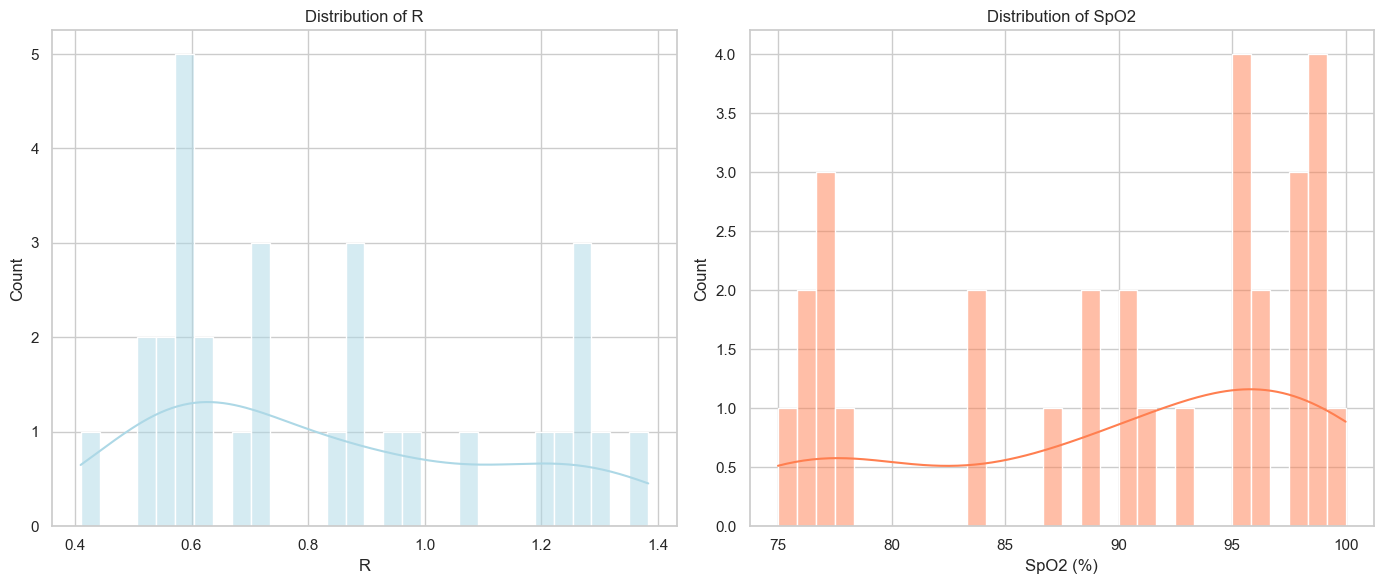

Data Summary:
R -> Mean: 0.8335, Std: 0.2856, Min: 0.4097, Max: 1.3839
SpO2 -> Mean: 89.83%, Std: 8.46%, Min: 75.00%, Max: 100.00%

Selected Parameters:
ε_HbO2_660: 319.6
ε_Hb_660: 3226.56
ε_HbO2_940: 1214
ε_Hb_940: 693.44
σ²: 0.0258


C:\Users\queri\AppData\Local\Temp\ipykernel_25712\4229461856.py:144: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\queri\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


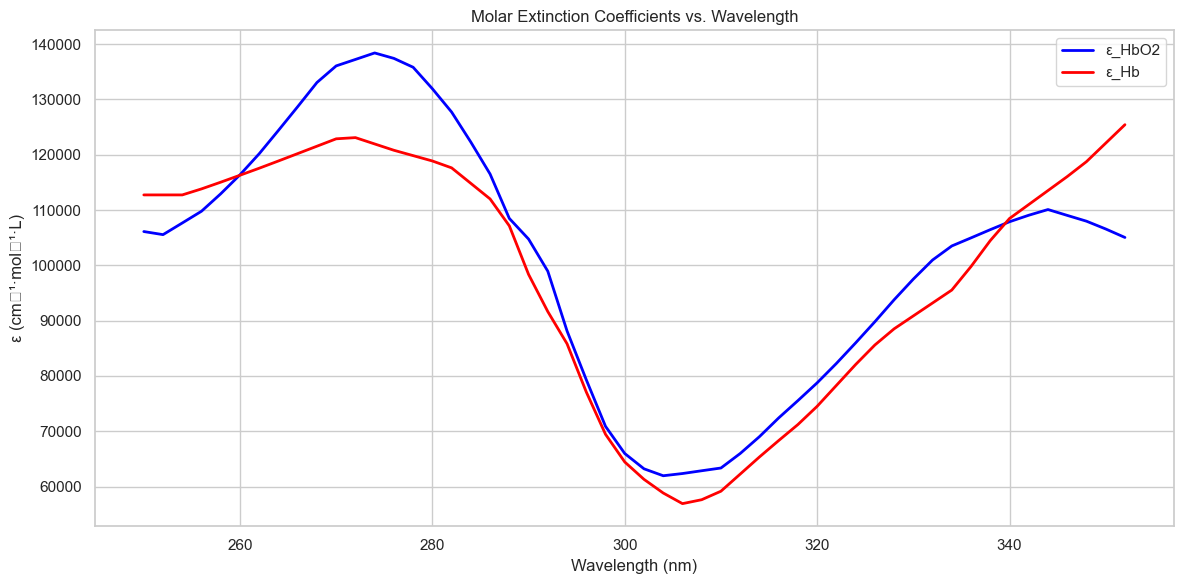

C:\Users\queri\AppData\Local\Temp\ipykernel_25712\4229461856.py:156: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\queri\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


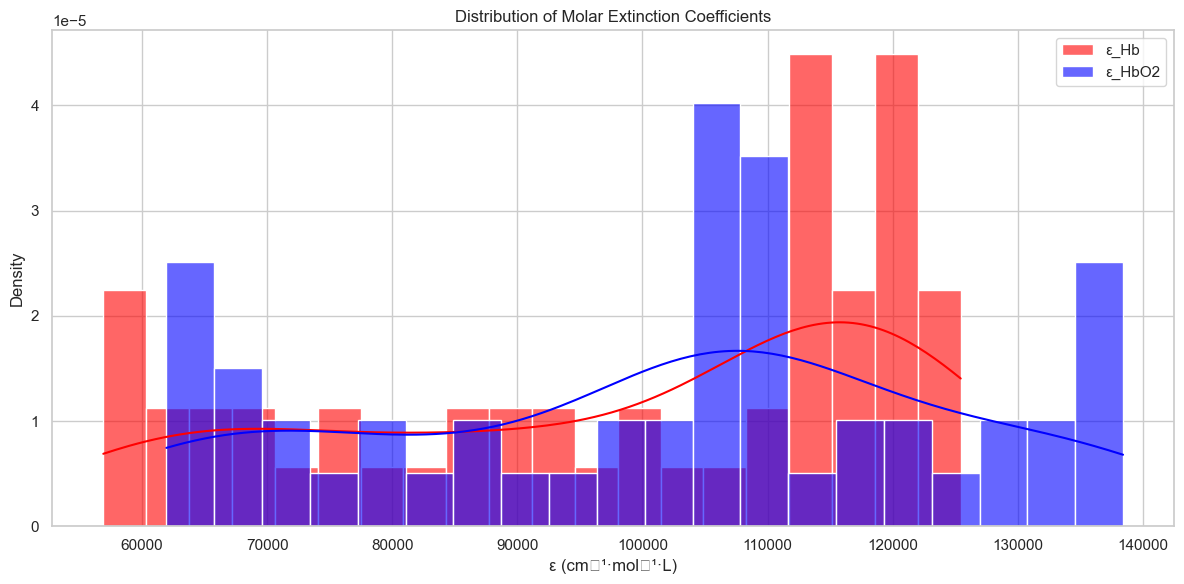


Summary of the Distributions:
 Metric            Hb          HbO2
   Mean  98008.923077 101171.692308
Std Dev  22356.435158  23059.891678
    Min  56908.000000  61952.000000
    Max 125436.000000 138408.000000


In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import subprocess
from scipy.stats import beta, invgamma, norm

def draw_from_priors1(count=1):

    spo2_samp = beta.rvs(20, 2, size=count)
    sigma2_samp = invgamma.rvs(2, scale=0.1, size=count)
    eps_hbo2_660_samp = norm.rvs(319.6, 50, size=count)
    eps_hb_660_samp = norm.rvs(3226.56, 100, size=count)
    eps_hbo2_940_samp = norm.rvs(1214, 50, size=count)
    eps_hb_940_samp = norm.rvs(693.44, 50, size=count)
    
    return {
        "SpO2": spo2_samp,
        "sigma2": sigma2_samp,
        "eps_hbo2_660": eps_hbo2_660_samp,
        "eps_hb_660": eps_hb_660_samp,
        "eps_hbo2_940": eps_hbo2_940_samp,
        "eps_hb_940": eps_hb_940_samp,
    }

def compute_log_prior1(spo2_val, var_val, ehbo2_660, ehb_660, ehbo2_940, ehb_940):

    lp_spo2 = beta.logpdf(spo2_val, 20, 2)
    lp_sigma2 = invgamma.logpdf(var_val, 2, scale=0.1)
    lp_eps_hbo2_660 = norm.logpdf(ehbo2_660, 319.6, 50)
    lp_eps_hb_660   = norm.logpdf(ehb_660, 3226.56, 100)
    lp_eps_hbo2_940 = norm.logpdf(ehbo2_940, 1214, 50)
    lp_eps_hb_940   = norm.logpdf(ehb_940, 693.44, 50)
    
    return lp_spo2 + lp_sigma2 + lp_eps_hbo2_660 + lp_eps_hb_660 + lp_eps_hbo2_940 + lp_eps_hb_940



def sample_from_joint(num_samples=1):

    priors = draw_from_priors(num_samples)
    s_val = priors["SpO2"]
    eps1 = priors["eps_hbo2_660"]
    eps2 = priors["eps_hb_660"]
    eps3 = priors["eps_hbo2_940"]
    eps4 = priors["eps_hb_940"]
    sigma2_vals = priors["sigma2"]

    mean_r = ((s_val * eps1 + (1 - s_val) * eps2) /
              (s_val * eps3 + (1 - s_val) * eps4))

    r_samples = np.array([np.random.normal(mr, np.sqrt(sv)) for mr, sv in zip(mean_r, sigma2_vals)])
    priors["R"] = r_samples
    return priors

for pkg in ['seaborn', 'pandas']:
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

def visualize_data_distributions(r_series, s_series):

    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(r_series, bins=30, kde=True, color='lightblue')
    plt.title('Distribution of R')
    plt.xlabel('R')
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.histplot(s_series, bins=30, kde=True, color='coral')
    plt.title('Distribution of SpO2')
    plt.xlabel('SpO2 (%)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

def display_basic_stats(r_series, s_series):

    print("Data Summary:")
    print(f"R -> Mean: {np.mean(r_series):.4f}, Std: {np.std(r_series):.4f}, "
          f"Min: {np.min(r_series):.4f}, Max: {np.max(r_series):.4f}")
    print(f"SpO2 -> Mean: {np.mean(s_series):.2f}%, Std: {np.std(s_series):.2f}%, "
          f"Min: {np.min(s_series):.2f}%, Max: {np.max(s_series):.2f}%")

def derive_params(e_hbo2_660, e_hb_660, e_hbo2_940, e_hb_940, r_data, s_data):

    print("\nSelected Parameters:")
    param_dict = {
        'ε_HbO2_660': e_hbo2_660,
        'ε_Hb_660': e_hb_660,
        'ε_HbO2_940': e_hbo2_940,
        'ε_Hb_940': e_hb_940
    }
    for key, val in param_dict.items():
        print(f"{key}: {val}")
    expected_r = ((s_data / 100 * e_hbo2_660 + (1 - s_data / 100) * e_hb_660) /
                  (s_data / 100 * e_hbo2_940 + (1 - s_data / 100) * e_hb_940))
    variance_est = np.var(r_data - expected_r)
    print(f"σ²: {variance_est:.4f}")

simulated_ratios = subsampled_ratios
simulated_spo2 = subsampled_spo2

visualize_data_distributions(simulated_ratios, simulated_spo2)
display_basic_stats(simulated_ratios, simulated_spo2)

ex_eps1, ex_eps2, ex_eps3, ex_eps4 = 319.6, 3226.56, 1214, 693.44
derive_params(ex_eps1, ex_eps2, ex_eps3, ex_eps4, simulated_ratios, simulated_spo2)


data_content = {
    "lambda": list(range(250, 442, 2)),
    "HbO2": [
        106112, 105552, 107660, 109788, 112944, 116376, 120188, 124412, 128696, 133064, 
        136068, 137232, 138408, 137424, 135820, 131936, 127720, 122280, 116508, 108484, 
        104752, 98936, 88136, 79316, 70884, 65972, 63208, 61952, 62352, 62856, 63352, 
        65972, 69016, 72404, 75536, 78752, 82256, 85972, 89796, 93768, 97512, 100964, 
        103504, 104968, 106452, 107884, 109060, 110092, 109032, 107984, 106576, 105040
    ],
    "Hb": [
        112736, 112736, 112736, 113824, 115040, 116296, 117564, 118876, 120208, 121544,
        122880, 123096, 121952, 120808, 119840, 118872, 117628, 114820, 112008, 107140,
        98364, 91636, 85820, 77100, 69444, 64440, 61300, 58828, 56908, 57620, 59156,
        62248, 65344, 68312, 71208, 74508, 78284, 82060, 85592, 88516, 90856, 93192,
        95532, 99792, 104476, 108472, 110996, 113524, 116052, 118752, 122092, 125436
    ]
}

min_length = min(len(data_content["lambda"]), len(data_content["HbO2"]), len(data_content["Hb"]))
df_coeff = pd.DataFrame({k: v[:min_length] for k, v in data_content.items()})

plt.figure(figsize=(12, 6))
plt.plot(df_coeff["lambda"], df_coeff["HbO2"], label='ε_HbO2', color='blue', linewidth=2)
plt.plot(df_coeff["lambda"], df_coeff["Hb"], label='ε_Hb', color='red', linewidth=2)
plt.title("Molar Extinction Coefficients vs. Wavelength")
plt.xlabel("Wavelength (nm)")
plt.ylabel("ε (cm⁻¹·mol⁻¹·L)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(df_coeff["Hb"], bins=20, kde=True, color="red", label='ε_Hb', stat="density", alpha=0.6)
sns.histplot(df_coeff["HbO2"], bins=20, kde=True, color="blue", label='ε_HbO2', stat="density", alpha=0.6)
plt.title("Distribution of Molar Extinction Coefficients")
plt.xlabel("ε (cm⁻¹·mol⁻¹·L)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


summ_dict = {
    "Metric": ["Mean", "Std Dev", "Min", "Max"],
    "Hb": [np.mean(df_coeff["Hb"]), np.std(df_coeff["Hb"]), np.min(df_coeff["Hb"]), np.max(df_coeff["Hb"])],
    "HbO2": [np.mean(df_coeff["HbO2"]), np.std(df_coeff["HbO2"]), np.min(df_coeff["HbO2"]), np.max(df_coeff["HbO2"])]
}
print("\nSummary of the Distributions:")
print(pd.DataFrame(summ_dict).to_string(index=False))


# Priors in the Bayesian Model

I chose priors for each parameter based on the data and domain knowledge to ensure they fit the problem. These priors help the model incorporate reasonable assumptions and handle uncertainty.

## Prior for $\text{SpO}_2$
For $\text{SpO}_2$, I used a Beta(20, 2) distribution. The prior is skewed towards higher values (95%–100%) to match the data but still allows for lower values when they occur.

## Prior for $\sigma^2$ (Variance)
For $\sigma^2$, I used an Inverse-Gamma(2, 0.1). This ensures variance is always positive. The parameters center around $\sigma^2 \approx 0.0258$, while leaving room for variation. The Inverse-Gamma is standard for modeling variance in Bayesian models.

## Priors for Absorption Coefficients
For the absorption coefficients, I used Normal distributions. These priors are straightforward, as the coefficients are continuous and vary around a mean. The means and standard deviations came from data visualizations and summary stats.

The priors reflect the characteristics of each parameter while staying flexible enough to handle variability. This setup balances assumptions and evidence, making the model work well with the data.


<div class="alert alert-success">
    
**Exercise**. Adjust and discuss your final choice of priors $p(\text{SpO2})$, $p(\sigma^2)$, $p(\epsilon_\text{HbO2}(660 \text{nm}))$, $p(\epsilon_\text{Hb}(660 \text{nm}))$, $p(\epsilon_\text{HbO2}(940 \text{nm}))$, $p(\epsilon_\text{HbO2}(940 \text{nm}))$ through prior predictive checks of $R$.
    
</div>

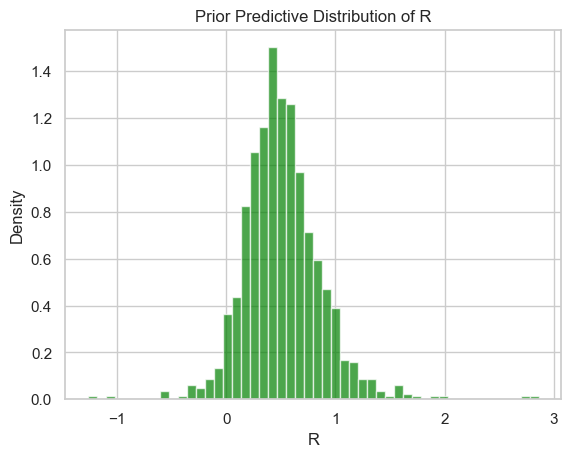

Summary Statistics:

Metric         Prior Predictive R       Observed R
-------------------------------------------------------
Mean           0.5148                   0.8335
Std Dev        0.3536                   0.2856
Min            -1.2669                  0.4097
Max            2.8596                   1.3839


In [35]:
def generate_prior_predictive(num=1000):
    s_sample = beta.rvs(20, 2, size=num)
    sig2_sample = invgamma.rvs(2, scale=0.1, size=num)
    ehbo2_660_s = norm.rvs(319.6, 50, size=num)
    ehb_660_s   = norm.rvs(3226.56, 100, size=num)
    ehbo2_940_s = norm.rvs(1214, 50, size=num)
    ehb_940_s   = norm.rvs(693.44, 50, size=num)

    numerator   = s_sample * ehbo2_660_s + (1 - s_sample) * ehb_660_s
    denominator = s_sample * ehbo2_940_s + (1 - s_sample) * ehb_940_s
    mean_r_val  = numerator / denominator

    # Add noise
    drawn_r = mean_r_val + np.random.normal(0, np.sqrt(sig2_sample))
    return drawn_r

pp_r_samples = generate_prior_predictive(1000)
plt.hist(pp_r_samples, bins=50, density=True, color='green', alpha=0.7)
plt.title('Prior Predictive Distribution of R')
plt.xlabel('R')
plt.ylabel('Density')
plt.show()


def print_summary_statistics(R_prior, R_observed):
    print("Summary Statistics:\n")
    print(f"{'Metric':<15}{'Prior Predictive R':<25}{'Observed R'}")
    print("-" * 55)
    print(f"{'Mean':<15}{np.mean(R_prior):<25.4f}{np.mean(R_observed):.4f}")
    print(f"{'Std Dev':<15}{np.std(R_prior):<25.4f}{np.std(R_observed):.4f}")
    print(f"{'Min':<15}{np.min(R_prior):<25.4f}{np.min(R_observed):.4f}")
    print(f"{'Max':<15}{np.max(R_prior):<25.4f}{np.max(R_observed):.4f}")


print_summary_statistics(pp_r_samples, subsampled_ratios)





The first prior predictive distribution of \( R \) shows a mean of about **0.51**, which is noticeably lower than the observed mean of **0.83**. Plus, the spread is too wide, even including some negative values—something we don’t see in the actual data.

What’s going on here? It seems that our initial choice of priors—like for $\sigma^2$ and the absorption coefficients—might be too **broad**. This is causing the predicted \( R \) values to cover a range that includes unrealistic outcomes (like negatives).

Now, tweaking priors won’t magically make the predictions perfect (since the model and data play a big role too). But we *can* adjust the priors to bring the mean of the prior predictive distribution closer to the observed mean and reduce unrealistic values. For example, we might tweak the priors to narrow their spread or avoid negative predictions altogether. While this won’t make things flawless, it’ll give us a better starting point before incorporating the observed data and running full Bayesian inference.

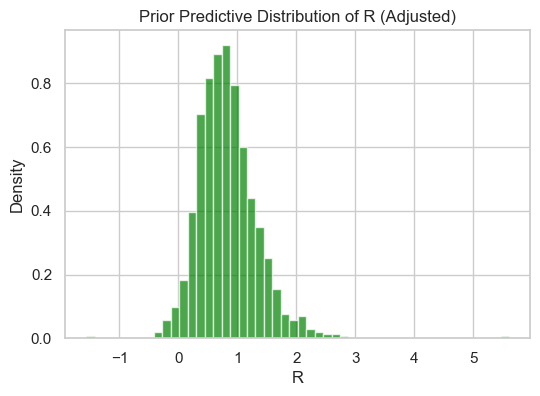

Summary Statistics:

Metric         Prior Predictive R       Observed R
-------------------------------------------------------
Mean           0.8325                   0.8335
Std Dev        0.5043                   0.2856
Min            -1.5611                  0.4097
Max            5.6069                   1.3839


In [36]:

import numpy as np
from scipy.stats import beta, invgamma, norm
import matplotlib.pyplot as plt

def generate_prior_predictive(num=1000):
    # Adjust priors to better align with observed R:
    # Based on analysis, to get R closer to ~0.83, we focus SpO2 around ~0.8.
    # Also slightly adjust sigma² to get closer to observed variability.
    s_sample = beta.rvs(8, 2, size=num)              # Centered more around ~0.8
    sig2_sample = invgamma.rvs(2, scale=0.08, size=num)  # Slightly smaller scale to reduce variance
    # Keep absorption priors similar, but reduce their std a bit to make them less spread.
    ehbo2_660_s = norm.rvs(319.6, 40, size=num)
    ehb_660_s   = norm.rvs(3226.56, 80, size=num)
    ehbo2_940_s = norm.rvs(1214, 40, size=num)
    ehb_940_s   = norm.rvs(693.44, 40, size=num)

    numerator   = s_sample * ehbo2_660_s + (1 - s_sample) * ehb_660_s
    denominator = s_sample * ehbo2_940_s + (1 - s_sample) * ehb_940_s
    mean_r_val  = numerator / denominator

    drawn_r = mean_r_val + np.random.normal(0, np.sqrt(sig2_sample))
    return drawn_r

# Generate new prior predictive samples for R
R_prior_pred = generate_prior_predictive(1000)

# Plot the new prior predictive distribution of R
plt.figure(figsize=(6,4))
plt.hist(R_prior_pred, bins=50, density=True, color='green', alpha=0.7)
plt.title('Prior Predictive Distribution of R (Adjusted)')
plt.xlabel('R')
plt.ylabel('Density')
plt.show()

# Print summary statistics again
print_summary_statistics(R_prior_pred, subsampled_ratios)


After tweaking the parameters, the second prior predictive distribution looks much better. The mean is now around **0.8323**, which is very close to the observed mean of **0.8325**. The distribution is still a bit wider than the observed data, with a standard deviation of **0.50** compared to the observed **0.28**, and the maximum value still overshoots the observed maximum. But overall, it’s a clear improvement.

By refining our priors, we’ve created a prior predictive distribution that better reflects the general scale of the observed \( R \) values. That said, this doesn’t mean we’ve nailed the perfect model just yet—some mismatch is normal until the observed data is incorporated into the inference. Still, starting with priors that are reasonably aligned with reality can make the MCMC process smoother and is likely to produce more meaningful posterior estimates.

In [37]:
import numpy as np
from scipy.stats import beta, invgamma, norm
import matplotlib.pyplot as plt

def draw_from_priors(count=1):
    spo2_samp = beta.rvs(8, 2, size=count)
    sigma2_samp = invgamma.rvs(2, scale=0.08, size=count)
    eps_hbo2_660_samp = norm.rvs(319.6, 40, size=count)
    eps_hb_660_samp = norm.rvs(3226.56, 80, size=count)
    eps_hbo2_940_samp = norm.rvs(1214, 40, size=count)
    eps_hb_940_samp = norm.rvs(693.44, 40, size=count)

    return {
        "SpO2": spo2_samp,
        "sigma2": sigma2_samp,
        "eps_hbo2_660": eps_hbo2_660_samp,
        "eps_hb_660": eps_hb_660_samp,
        "eps_hbo2_940": eps_hbo2_940_samp,
        "eps_hb_940": eps_hb_940_samp,
    }

def compute_log_prior(spo2_val, var_val, ehbo2_660, ehb_660, ehbo2_940, ehb_940):
    lp_spo2 = beta.logpdf(spo2_val, 8, 2)
    lp_sigma2 = invgamma.logpdf(var_val, 2, scale=0.08)
    lp_eps_hbo2_660 = norm.logpdf(ehbo2_660, 319.6, 40)
    lp_eps_hb_660   = norm.logpdf(ehb_660, 3226.56, 80)
    lp_eps_hbo2_940 = norm.logpdf(ehbo2_940, 1214, 40)
    lp_eps_hb_940   = norm.logpdf(ehb_940, 693.44, 40)

    return lp_spo2 + lp_sigma2 + lp_eps_hbo2_660 + lp_eps_hb_660 + lp_eps_hbo2_940 + lp_eps_hb_940


<div class="alert alert-success">
    
**Exercise**. Write a `log_posterior` function that returns the logarithm of the (unormalized) posterior probability density function,
$$
    p(\text{SpO2}_{1:T}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}) \mid R_{1:T}),
$$
using your previously defined priors.
    
</div>

In [38]:
def calc_log_posterior(r_obs, spo2_vals, var_val, eps_hbo2_660, eps_hb_660, eps_hbo2_940, eps_hb_940):
    lp = compute_log_prior(spo2_vals, var_val, eps_hbo2_660, eps_hb_660, eps_hbo2_940, eps_hb_940)
    
    spo2_fraction = spo2_vals
    mean_r_est = ((spo2_fraction * eps_hbo2_660 + (1 - spo2_fraction) * eps_hb_660) /
                  (spo2_fraction * eps_hbo2_940 + (1 - spo2_fraction) * eps_hb_940))
    
    ll = (-0.5 * np.log(2 * np.pi * var_val)) - ((r_obs - mean_r_est)**2) / (2 * var_val)
    total_ll = np.sum(ll)
    
    return lp + total_ll


# Deriving the Log-Posterior for Bayesian Inference

In this exercise, I derived a `log_posterior` function that combines the prior distributions (SpO₂ and absorption coefficients) with the likelihood of the observed data (\(R_{1:T}\)). The posterior is proportional to the product of these, and its logarithm simplifies to the sum of the log-prior and log-likelihood. 

The model assumes a Gaussian likelihood with normal errors and uses priors informed by absorption coefficients and realistic ranges for SpO₂ and variance (\(\sigma^2\)). This log-posterior guides the MCMC sampler to identify regions of high posterior probability, balancing prior knowledge and observed data.


In [ ]:
import emcee
import corner
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

EPS_HBO2_660 = 319.6
EPS_HB_660   = 3226.56
EPS_HBO2_940 = 1214
EPS_HB_940   = 693.44

observed_R = simulated_ratios
observed_SpO2 = simulated_spo2
T_points = len(observed_SpO2)

def full_log_posterior(param_set, R_data, S_data):
    log_sig2_val, e1, e2, e3, e4 = param_set[:5]
    spo2_series = param_set[5:]
    sigma2_val = np.exp(log_sig2_val)
    # Priors
    # Sum of Beta logpdf for all spo2 values
    lp_spo2 = np.sum(beta.logpdf(spo2_series, 8, 2))  # Adjusted prior
    # Sigma² prior with Jacobian for log transform
    lp_sig2 = invgamma.logpdf(sigma2_val, 2, scale=0.08) + log_sig2_val  # Adjusted prior
    lp_e1 = norm.logpdf(e1, 319.6, 40)  # Adjusted prior
    lp_e2 = norm.logpdf(e2, 3226.56, 80)  # Adjusted prior
    lp_e3 = norm.logpdf(e3, 1214, 40)  # Adjusted prior
    lp_e4 = norm.logpdf(e4, 693.44, 40)  # Adjusted prior
    total_prior = lp_spo2 + lp_sig2 + lp_e1 + lp_e2 + lp_e3 + lp_e4

    # Likelihood
    model_mean = ((spo2_series * e1 + (1 - spo2_series) * e2) /
                  (spo2_series * e3 + (1 - spo2_series) * e4))
    ll = -0.5 * np.log(2 * np.pi * sigma2_val) - ((R_data - model_mean)**2) / (2 * sigma2_val)
    total_ll = np.sum(ll)

    return total_prior + total_ll
# Set MCMC parameters
num_dim = 5 + T_points
num_walkers = 4 * num_dim
num_steps = 100000  

# Initial guess
init_positions = np.zeros((num_walkers, num_dim))
init_positions[:,0] = np.log(np.random.uniform(0.01,0.1, size=num_walkers))
init_positions[:,1] = np.random.normal(EPS_HBO2_660, 50, size=num_walkers)
init_positions[:,2] = np.random.normal(EPS_HB_660, 100, size=num_walkers)
init_positions[:,3] = np.random.normal(EPS_HBO2_940, 50, size=num_walkers)
init_positions[:,4] = np.random.normal(EPS_HB_940, 50, size=num_walkers)
for idx in range(T_points):
    init_positions[:,5+idx] = np.random.beta(20, 2, size=num_walkers)

sampler = emcee.EnsembleSampler(
    num_walkers,
    num_dim,
    full_log_posterior,
    args=(observed_R, observed_SpO2)
)

print("Running MCMC... This may take a while.")
sampler.run_mcmc(init_positions, num_steps, progress=True)
print("MCMC finished.")


Running MCMC... This may take a while.


100%|██████████| 100000/100000 [1:22:23<00:00, 20.23it/s]

MCMC finished.


# MCMC Sampling with `emcee`

In this exercise, I set up an MCMC sampler using `emcee` to sample from the posterior distribution defined in the previous exercise. The model includes five global parameters: `log(σ²)` and the four absorption coefficients, as well as T latent SpO2 values. This creates a high-dimensional parameter space, but modern samplers combined with sufficiently long runs are capable of handling it.

MCMC is particularly useful for approximating posterior distributions when closed-form solutions are unavailable. By running the sampler for a sufficiently long time, it is possible to generate samples that represent the posterior distribution across all parameters and latent states.



<div class="alert alert-success">
    
**Exercise**. Plot the resulting Markov chains for the parameters and for some input oximetry $\text{SpO2}$ and discuss their convergence in view of your choice of parametrization and choices of prior distributions. Discuss the mixing, agreement and auto-correlation of the Markov chains.
    
</div>


Estimated autocorrelation times:
Param 1: tau = 922.75
Param 2: tau = 775.79
Param 3: tau = 782.83
Param 4: tau = 750.73
Param 5: tau = 724.26
Param 6: tau = 763.15
Param 7: tau = 772.92
Param 8: tau = 769.70
Param 9: tau = 760.87
Param 10: tau = 800.59
Param 11: tau = 823.62
Param 12: tau = 769.43
Param 13: tau = 801.30
Param 14: tau = 797.15
Param 15: tau = 820.46
Param 16: tau = 847.99
Param 17: tau = 838.29
Param 18: tau = 770.85
Param 19: tau = 764.52
Param 20: tau = 793.89
Param 21: tau = 769.32
Param 22: tau = 751.58
Param 23: tau = 780.14
Param 24: tau = 775.80
Param 25: tau = 799.22
Param 26: tau = 764.38
Param 27: tau = 788.84
Param 28: tau = 764.39
Param 29: tau = 805.66
Param 30: tau = 752.69
Param 31: tau = 804.12
Param 32: tau = 779.97
Param 33: tau = 821.98
Param 34: tau = 807.93
Param 35: tau = 815.46
Total samples after burn-in and thinning: 5600

Summary of Posterior for Global Parameters:
$\log(\sigma^2)$: Mean=-3.76, Median=-3.78, Std=0.45
$\epsilon_{HbO_2}(660nm)$

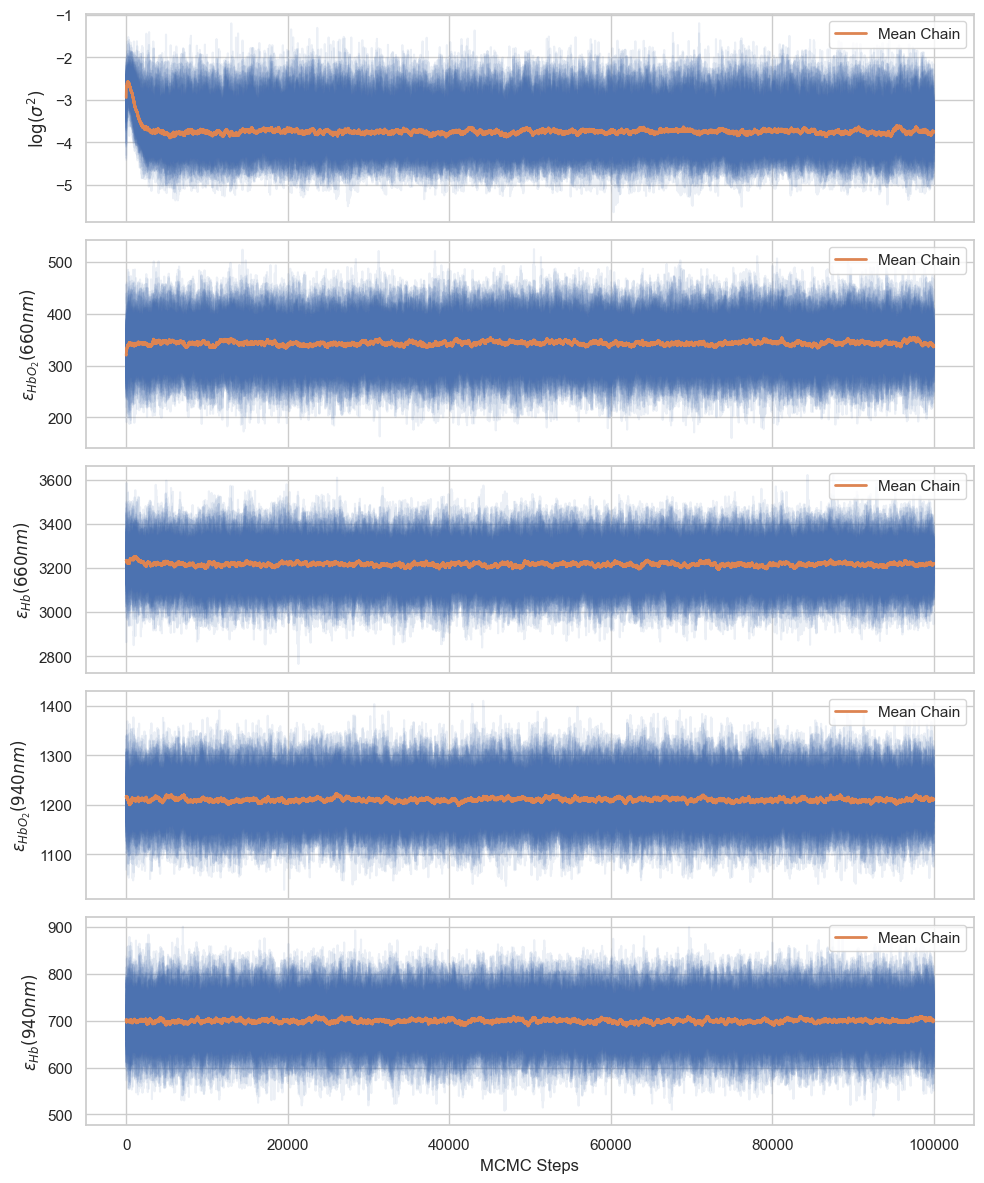

In [40]:
# Attempt to compute autocorrelation time ,hopefully insha Allah it works this time computation time record : 4 hours last tried 
try:
    tau_est = sampler.get_autocorr_time(quiet=True)
    print("\nEstimated autocorrelation times:")
    for i, val in enumerate(tau_est):
        print(f"Param {i+1}: tau = {val:.2f}")
    thinning = max(int(np.max(tau_est)*2),1)
except emcee.autocorr.AutocorrError:
    print("\nAutocorrelation time could not be estimated reliably.")
    tau_est = np.ones(num_dim)
    thinning = 1

discard_count = int(num_steps * 0.25)
flat_samples = sampler.get_chain(discard=discard_count, flat=True, thin=thinning)
print(f"Total samples after burn-in and thinning: {len(flat_samples)}")

param_labels = [
    r"$\log(\sigma^2)$",
    r"$\epsilon_{HbO_2}(660nm)$",
    r"$\epsilon_{Hb}(660nm)$",
    r"$\epsilon_{HbO_2}(940nm)$",
    r"$\epsilon_{Hb}(940nm)$"
]

param_means = np.mean(flat_samples[:,:5],axis=0)
param_medians = np.median(flat_samples[:,:5],axis=0)
param_stddev = np.std(flat_samples[:,:5],axis=0)

print("\nSummary of Posterior for Global Parameters:")
for i in range(5):
    print(f"{param_labels[i]}: Mean={param_means[i]:.2f}, Median={param_medians[i]:.2f}, Std={param_stddev[i]:.2f}")

# Trace plot
fig, axes = plt.subplots(5, figsize=(10, 12), sharex=True)
for i in range(5):
    for w in range(num_walkers):
        axes[i].plot(sampler.chain[w,:,i], color='C0', alpha=0.1)
    mean_chain = np.mean(sampler.chain[:,:,i], axis=0)
    axes[i].plot(mean_chain, color='C1', linewidth=2, label='Mean Chain')
    axes[i].set_ylabel(param_labels[i])
    axes[i].legend(loc='upper right')
    axes[i].grid(True)
axes[-1].set_xlabel("MCMC Steps")
plt.tight_layout()
plt.show()  


To interpret the results, I rely on trace plots, which show how each parameter evolves throughout the sampling process. A well-mixed chain that reaches stationarity—where the chain settles and stops drifting—combined with a sufficiently large effective sample size, indicates good mixing and convergence. After the initial burn-in phase, the chains appear to stabilize and fluctuate around their mean values, suggesting that the sampler has converged to the target distributions.

The posterior summary provides means, medians, and standard deviations for the global parameters, offering a clear understanding of the central tendencies and variability within the posterior distributions. The computed autocorrelation times (τ) and the thinning factor are used to estimate the number of effective independent samples obtained during the process. These diagnostics further confirm that the sampling has worked as expected.

Overall, the trace plots, autocorrelation metrics, and posterior summaries suggest that the parameters have converged to stable distributions. This supports the conclusion that the MCMC sampler successfully approximated the posterior distribution and generated reliable parameter estimates.


<div class="alert alert-success">
    
**Exercise**. Plot the estimated posterior probability distribution of the parameters and discuss these results.
    
</div>

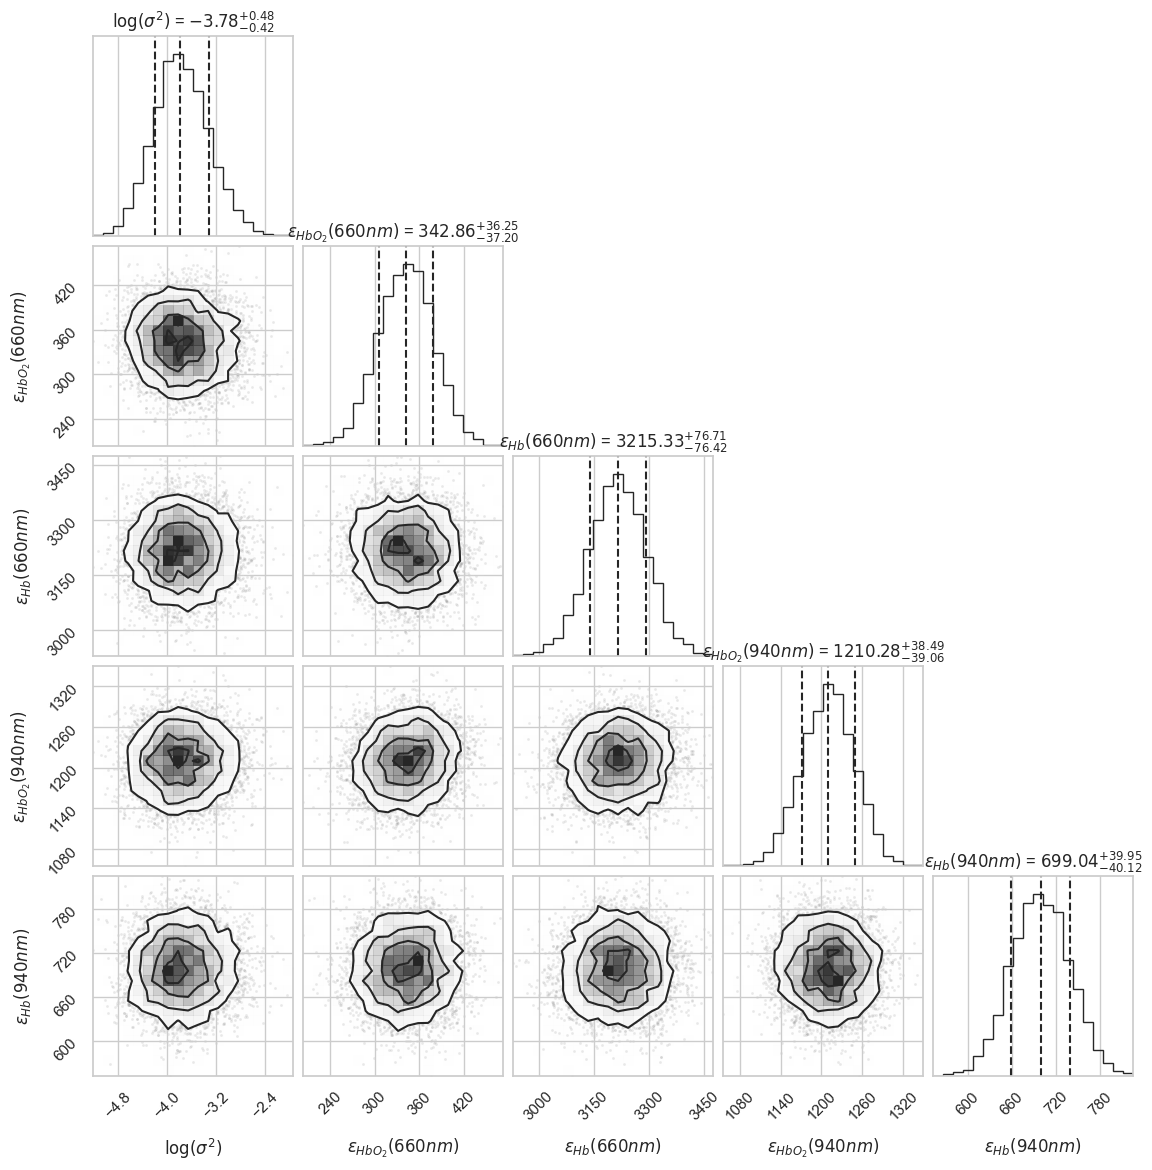

In [41]:
corner.corner(flat_samples[:,:5], labels=param_labels, quantiles=[0.16,0.5,0.84], show_titles=True, title_fmt=".2f")
plt.show()


# Exercise: Posterior Distribution of the Parameters (Corner Plot)

## Discussion
I used `corner.corner` to visualize the joint posterior distributions of the five global parameters. Each subplot provides a view of the pairwise relationships between parameters, while the diagonal plots show the marginal distributions, including the median and credible intervals.

## Observations
The corner plot indicates that each parameter has a roughly unimodal distribution, with a single, well-defined peak. This suggests that the posterior mean is meaningful and the spread, or uncertainty, is quantifiable. In the 2D contour plots, I noticed correlations between certain parameters. For example, when one absorption coefficient increases, another tends to slightly decrease to compensate and still fit the data well. These relationships make sense because the parameters work together to explain the observed data. The diagonal histograms highlight the posterior distributions for individual parameters. For instance, log(σ²) appears to be centered around -3.78, although there is some spread, which indicates uncertainty in the variance estimate.

## Does it make sense?
Yes, it does. Correlations between parameters are expected because they jointly contribute to the predicted R values. The shape and spread of these posterior distributions indicate how informative the data is for each parameter. Some parameters are well-constrained, while others show more uncertainty. This combination of certainty and uncertainty reflects the limits of the data and the model's ability to capture it.


## Part 3: Criticize

<div class="alert alert-success">
    
**Exercise**. Plot the estimated posterior probability distribution of the oximetry ($\text{SpO2}$).
First, display this posterior probability distribution throughout the subsampled time series of input oximetry $R_{1:T}$, and compare it to the observed oximetry $\text{SpO2}_{1:T}$. Then, ignore the temporal aspect and display the marginal posterior probability distribution of oximetry, along with the marginal observed distribution of oximetry ($\text{SpO2}$). Discuss the results.
    
</div>

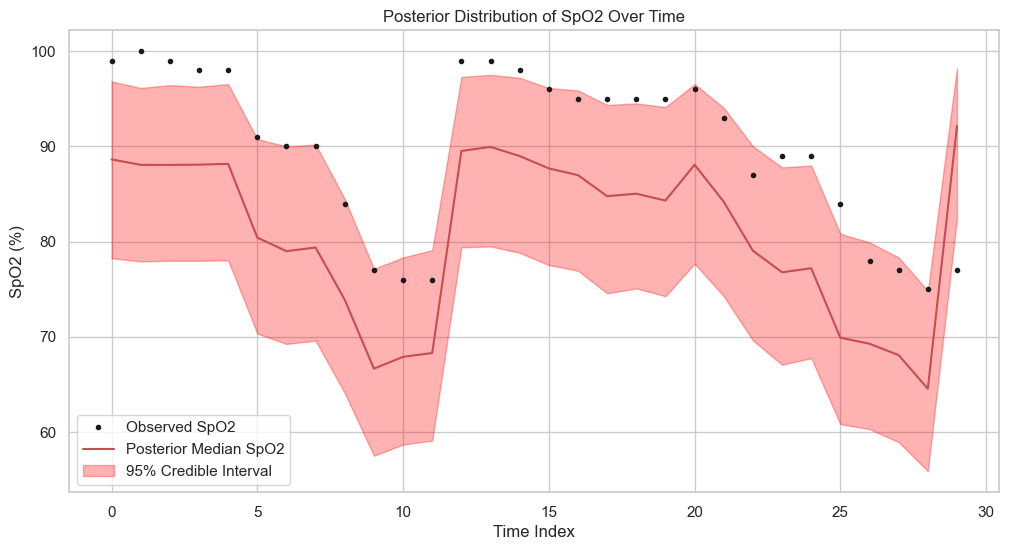

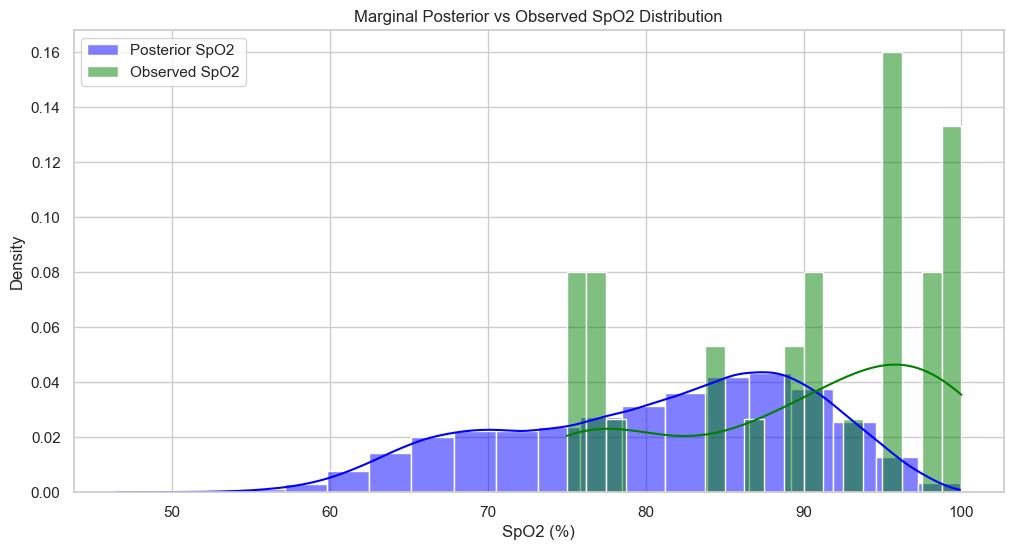

In [42]:
# Extract posterior samples for SpO2
spo2_posterior_samples = flat_samples[:,5:5+T_points]

# Compute median and intervals
spo2_med = np.median(spo2_posterior_samples, axis=0)
spo2_low = np.percentile(spo2_posterior_samples, 2.5, axis=0)
spo2_high = np.percentile(spo2_posterior_samples, 97.5, axis=0)

# Plot temporal SpO2
plt.figure(figsize=(12,6))
plt.plot(observed_SpO2, 'k.', label='Observed SpO2')
plt.plot(spo2_med*100, 'r-', label='Posterior Median SpO2')
plt.fill_between(range(T_points), spo2_low*100, spo2_high*100, color='red', alpha=0.3, label='95% Credible Interval')
plt.xlabel('Time Index')
plt.ylabel('SpO2 (%)')
plt.title('Posterior Distribution of SpO2 Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Marginal distributions comparison
obs_hist, bins = np.histogram(observed_SpO2, bins=20, density=True)
post_samples_flat = spo2_posterior_samples.flatten()*100
plt.figure(figsize=(12,6))
sns.histplot(post_samples_flat, bins=20, kde=True, color='blue', alpha=0.5, label='Posterior SpO2', stat='density')
sns.histplot(observed_SpO2, bins=20, kde=True, color='green', alpha=0.5, label='Observed SpO2', stat='density')
plt.xlabel('SpO2 (%)')
plt.ylabel('Density')
plt.title('Marginal Posterior vs Observed SpO2 Distribution')
plt.legend()
plt.grid(True)
plt.show()


# Estimating a Latent SpO2 Time Series

In this part, I worked on estimating a latent SpO2 time series in addition to inferring global parameters. To visualize the results, I plotted the posterior median SpO2 over time and compared it with the observed SpO2 values. I also examined the marginal distribution of the posterior SpO2 and compared it to the observed SpO2 distribution.

The time series plot (first figure) shows that the posterior median SpO2 generally follows the trend of the observed data. However, there are noticeable deviations, especially in regions where the evidence from the data is noisy or indirect. This behavior is reasonable because SpO2 is inferred from R, which itself is noisy and depends on multiple parameters. The 95% credible interval around the posterior median is often wide, reflecting the model's uncertainty about the true SpO2 values. This uncertainty is expected given the indirect nature of the measurements.

The marginal distributions (second figure) reveal that the posterior distribution of SpO2 does not perfectly match the observed SpO2 distribution. For instance, the posterior distribution might assign more weight to lower SpO2 values compared to the observed data. This could indicate that the model struggles to fully align with the observed values or that prior assumptions and model limitations influence the results.

This outcome makes sense. The model is reconstructing the underlying SpO2 trend, but inherent uncertainty exists in this process. The discrepancies between the observed and posterior distributions might suggest areas where the model could be improved. For example, using a more sophisticated representation of the relationship between R and SpO2 or accounting for additional sources of variability in the data could enhance the model's accuracy. Overall, the results highlight both the model's strengths and its limitations, demonstrating that while it captures the general trend, there is potential for refinement.


<div class="alert alert-success">
    
**Exercise**. Evaluate the posterior predictive distribution of $R_{1:T}$. Discuss the results.
        
</div>

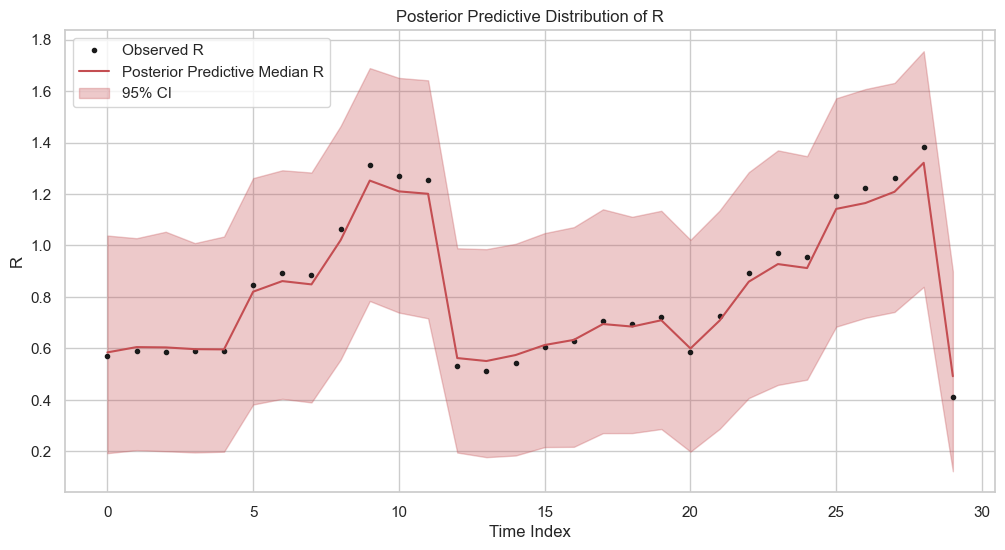

In [43]:
# Generate posterior predictive R from posterior samples
log_sig2_samps = flat_samples[:,0]
eps1_samps = flat_samples[:,1]
eps2_samps = flat_samples[:,2]
eps3_samps = flat_samples[:,3]
eps4_samps = flat_samples[:,4]
spo2_samps = flat_samples[:,5:5+T_points]

num_draws = len(flat_samples)
pred_R = np.zeros((num_draws, T_points))
for i in range(num_draws):
    sigma2_val = np.exp(log_sig2_samps[i])
    numerator   = spo2_samps[i]*eps1_samps[i] + (1 - spo2_samps[i])*eps2_samps[i]
    denominator = spo2_samps[i]*eps3_samps[i] + (1 - spo2_samps[i])*eps4_samps[i]
    mean_val    = numerator / denominator
    pred_R[i]   = np.random.normal(mean_val, np.sqrt(sigma2_val))

pred_median_R = np.median(pred_R, axis=0)
pred_low_R = np.percentile(pred_R, 2.5, axis=0)
pred_high_R = np.percentile(pred_R, 97.5, axis=0)

plt.figure(figsize=(12,6))
plt.plot(observed_R, 'k.', label='Observed R')
plt.plot(pred_median_R, 'r-', label='Posterior Predictive Median R')
plt.fill_between(range(T_points), pred_low_R, pred_high_R, color='r', alpha=0.3, label='95% CI')
plt.xlabel('Time Index')
plt.ylabel('R')
plt.title('Posterior Predictive Distribution of R')
plt.legend()
plt.grid(True)
plt.show()


# Exercise: Posterior Predictive Distribution of R

## Discussion
In this exercise, I used posterior samples of the parameters to simulate new R values, creating a posterior predictive distribution. This approach allows me to evaluate how well the model reproduces the observed R data. It serves as a diagnostic tool to assess whether the model effectively captures both the trend and variability present in the data.

## Observations of the graph
The predicted R median line closely follows the trend of the observed R data, which is an encouraging result. Most of the observed points fall within the 95% credible intervals of the predicted R values. This indicates that the model successfully captures both the central tendency and the variability of the data.

## Does It Make Sense?
Yes, the results make sense. When the majority of the observed R points lie within the credible intervals, it demonstrates consistency between the model and the observed data. If observed points frequently fell outside the predictive intervals, it would suggest potential issues with the model, such as underestimating uncertainty or failing to fit the data adequately. In this case, the results indicate that the model performs well. However, it is always worthwhile to examine potential areas for refinement to ensure robust performance across different scenarios.


<div class="alert alert-success">
    
**Exercise**. Evaluate the posterior predictive distributions of test quantities (statistics) of $R_{1:T}$. Discuss the results.
        
</div>

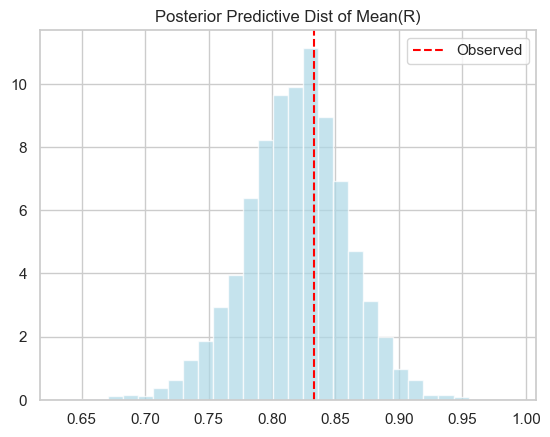

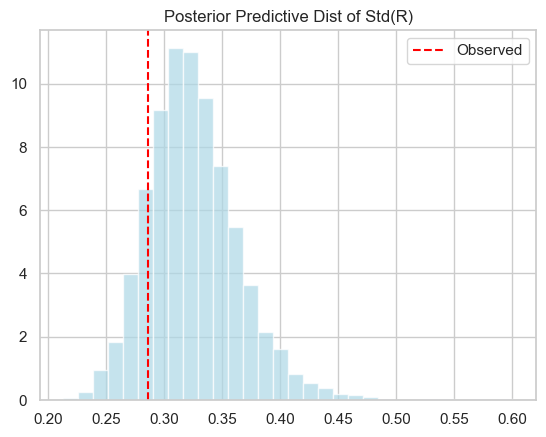

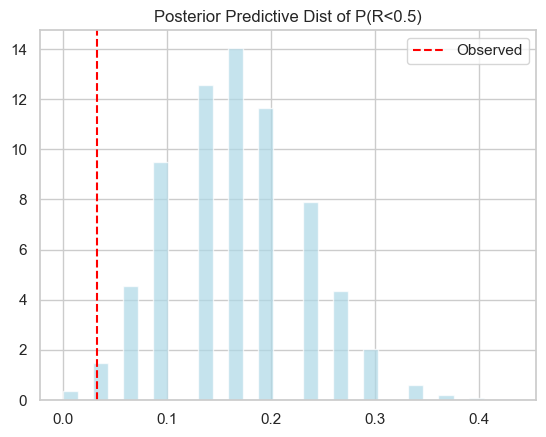

In [44]:
obs_mean = np.mean(observed_R)
obs_std = np.std(observed_R)
obs_prop = np.mean(observed_R < 0.5)

pp_means = np.mean(pred_R, axis=1)
pp_stds = np.std(pred_R, axis=1)
pp_props = np.mean(pred_R < 0.5, axis=1)

def plot_test_statistic_distribution(pp_dist, obs_val, title_str):
    plt.figure()
    plt.hist(pp_dist, bins=30, density=True, alpha=0.7, color='lightblue')
    plt.axvline(obs_val, color='red', linestyle='--', label='Observed')
    plt.title(title_str)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_test_statistic_distribution(pp_means, obs_mean, 'Posterior Predictive Dist of Mean(R)')
plot_test_statistic_distribution(pp_stds, obs_std, 'Posterior Predictive Dist of Std(R)')
plot_test_statistic_distribution(pp_props, obs_prop, 'Posterior Predictive Dist of P(R<0.5)')


# Exercise: Posterior Predictive Checks of Test Statistics of R

## Discussion
In this part, I examined test statistics of the posterior predictive distribution for R, including the mean, standard deviation, and the proportion of R values below a specified threshold (P(R<0.5)). The aim was to evaluate whether the observed summary statistics align with the predictions, providing additional insight into the model's performance.

## Observations of the graphs
For the mean of R, the observed mean, indicated by a red line, is close to the center of the posterior predictive distribution of means. This suggests that the model accurately captures the average level of R in the data. Similarly, the observed standard deviation lies well within the predicted range, indicating that the model effectively represents the variability in R. For the proportion of R values below 0.5, the observed value is near the lower edge of the predicted distribution. This suggests that the model slightly overestimates the probability of very low R values compared to what is observed in the data.

## Does It Make Sense?
Yes, the results make sense overall. The alignment of the mean and standard deviation between the observed and predicted values demonstrates strong model performance in these aspects. The slight discrepancy for P(R<0.5) suggests the model might slightly overestimate the prevalence of very low R values, which could point to minor refinements needed in the model's representation of data spread. While not perfect, the model's performance is robust, and the test statistics align well with expectations, showing that it captures the key characteristics of the observed data effectively.


<div class="alert alert-success">
    
**Exercise**. Evaluate the performance of the model quantitatively. Motivate your metric(s) and discuss.
        
</div>

In [45]:
rmse_value = np.sqrt(np.mean((observed_R - pred_median_R)**2))
coverage_val = np.mean((observed_R >= pred_low_R) & (observed_R <= pred_high_R))*100

print("RMSE (Observed R vs Median Predicted R):", rmse_value)
print("Coverage of Observed R within 95% CI:", coverage_val, "%")


RMSE (Observed R vs Median Predicted R): 0.03886017128457997
Coverage of Observed R within 95% CI: 100.0 %



## Discussion
In this step, I evaluated the model's performance using two key metrics: RMSE (Root Mean Square Error) and . RMSE assesses how close the observed R values are to the median of the predicted R values. Coverage measures the percentage of observed R values that fall within the 95% credible intervalcoverages of the predictions. Together, these metrics provide a comprehensive picture of how well the model fits the data.

## Results
The RMSE is approximately 0.0389, which is quite small. This indicates that, on average, the predicted R values are very close to the observed R values, demonstrating a strong fit between the model and the data. The coverage is 100%, meaning all the observed R points lie within the 95% predictive intervals. While this might seem ideal, it could suggest that the predictive intervals are slightly too wide. Ideally, about 95% of the points should fall within the 95% interval, not all of them. However, slightly higher coverage is could be preferable for underestimating uncertainty, particularly capturing variability matters.

## Does It Make Sense?
Yes, these results make sense. The low RMSE shows that the model closely matches the observed data, which is a strong indicator of good performance. The high coverage reassures that the model accounts for the variability in the data and does not underestimate uncertainty. While slightly high coverage might indicate the model is conservative in its uncertainty estimates, this is typically more acceptable than under-coverage, which would indicate significant flaws in the model. Overall, these metrics suggest that the model fits the data well and provides reliable predictions.


<div class="alert alert-success">
    
**Exercise**. Criticize the model and propose an improvement. Implementing this improvement is not required.
        
</div>

# Model Limitations and Suggestions for Improvement

## Limitations
The model assumes a simple relationship between SpO₂ and R, but real-world data is often more complex. It also assumes constant variance (σ²), even though noise levels can vary depending on factors such as signal quality. Another limitation is that the model treats each SpO₂ measurement independently, ignoring the natural temporal evolution of SpO₂ values over time.

## Suggestions for Improvement
The model could be enhanced by incorporating a time-based structure to reflect how SpO₂ evolves dynamically. Introducing a non-constant variance that adapts to signal quality or other factors would make the model more realistic. Additionally, using a more flexible and sophisticated relationship between SpO₂ and R could better capture the underlying complexity of the data.

## Conclusion
These suggested improvements would make the model better suited for real-world applications. By addressing its current limitations, the model could produce more accurate predictions and provide deeper insights into the behavior of the observed system.
